**Enable GPU** (Runtime > Change runtime type > GPU)

In [ ]:
!nvidia-smi

Tue Sep  6 11:09:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Clone MddGAN repo

In [ ]:
import os

os.chdir('/content')
CODE_DIR = 'mddgan'
!git clone https://github.com/lazavgeridis/mddgan.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')

Cloning into 'mddgan'...
remote: Enumerating objects: 358, done.
remote: Counting objects: 100% (358/358), done.
remote: Compressing objects: 100% (286/286), done.
remote: Total 358 (delta 148), reused 280 (delta 70), pack-reused 0
Receiving objects: 100% (358/358), 4.80 MiB | 35.13 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [ ]:
!pip install tensorly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 30.0 MB/s 
     |████████████████████████████████| 154 kB 68.6 MB/s 


Load Generator network (StyleGAN2 FFHQ)

In [ ]:
import torch
import numpy as np

from models import parse_gan_type
from utils  import load_generator, analyze_latent_space

#### ProGAN
#clevr_simple_config = dict(
#        gan_type='pggan',
#        resolution=128,
#        z_dim=12,
#        url='http://efrosgans.eecs.berkeley.edu/HessianPenalty/resources/pretrained_models/clevr_simple/simple_bl.pkl'
#)

model_name = 'stylegan2_ffhq1024'
generator = load_generator(model_name).cuda()
gan_type = parse_gan_type(generator)


#elif gan_model == 2:
#  model_config = clevr_simple_config.copy()
#  config_name = 'progan_clevrsimple'
#  url = model_config.pop('url')
#  generator = PGGANGenerator(model_config['resolution'], z_space_dim=model_config['z_dim'], fused_scale=True)

Building generator for model `stylegan2_ffhq1024` ...
Finish building generator.
Loading checkpoint from `checkpoints/stylegan2_ffhq1024.pth` ...
  Finish downloading checkpoint.
Finish loading checkpoint.


Sample latent vectors and do the 1st generation step, $G_1(\boldsymbol{z})$

In [ ]:
# set random seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

# prepare latent codes
num_samples = 3
latent_vectors = torch.randn(num_samples, generator.z_space_dim, device='cuda')
if gan_type == 'pggan':
  codes = generator.layer0.pixel_norm(latent_vectors)
elif gan_type in ['stylegan', 'stylegan2']:
  trunc_psi = 0.7
  trunc_layers = 8
  codes = generator.mapping(latent_vectors)['w']
  codes = generator.truncation(codes, trunc_psi=trunc_psi, trunc_layers=trunc_layers)
codes = codes.detach().cpu()

# prepare interpolation magnitudes
start = -5.0
end   = 5.0
step = 7
magnitudes = np.linspace(start, end, step)

Utility function

In [ ]:
from visualization import interpolation, postprocess

def create_interp_stripes(G, gan_type, layer_list, layer_str, basis, code, magnitudes, axs):
  interp_stripes = []

  if layer_str == 'all':
    start_idx = 0
    directions = basis[10:14]
    desc = ['All', 'All', 'All', 'All']
    for i in range(4):
      dir = directions[i]
      interp_stripes.append(interpolation(G, layer_list, gan_type, code, dir, magnitudes))
  
  elif layer_str == '0-3':
    start_idx = 4
    directions = basis[1:2]
    desc = ['Bottom']
    for i in range(1):
      dir = directions[i]
      interp_stripes.append(interpolation(G, layer_list, gan_type, code, dir, magnitudes))

  elif layer_str == '4-7':
    start_idx = 5
    directions = basis[10:11]
    desc = ['Middle']
    for i in range(1):
      dir = directions[i]
      interp_stripes.append(interpolation(G, layer_list, gan_type, code, dir, magnitudes))

  elif layer_str == '8-17':
    start_idx = 6
    directions = basis[6:7]
    desc = ['Top']
    for i in range(1):
      dir = directions[i]
      interp_stripes.append(interpolation(G, layer_list, gan_type, code, dir, magnitudes))
  
  for ax, direction_interp, text in zip(axs[start_idx:], interp_stripes, desc):
    ax.axis('off')
    ax.imshow(postprocess(make_grid(direction_interp, nrow=step)))
    ax.text(0, 0.5, 
            text, 
            horizontalalignment='right', 
            verticalalignment='center', 
            rotation='vertical',
            fontsize='small',
            transform=ax.transAxes)
  
  return axs

Apply the MDD algorithm on the following layers of $G$:
1. **All layers** : affects multiple facial attributes at once
2. **Layers 0-3** : affects overall shape of the image
3. **Layers 4-7** : affects smaller scale facial features
4. **Layers 8-17** : affects image lighting and color scheme

_Note_ : The initial image is located in the middle column.

Analyzing all layer indices:   0%|          | 0/4 [00:00<?, ?it/s]

2.0820474619309694e-12 3.463645729559679e-05 16635767.401514292
2.1205438386436216e-12 3.5276874064389544e-05 16635767.401514292
2.01935063438884e-12 3.359344745579307e-05 16635767.401514292
2.1718802007639073e-12 3.613089384386253e-05 16635767.401514292
2.052784144478701e-12 3.414963955306418e-05 16635767.401514292


Analyzing 0-3 layer indices:  25%|██▌       | 1/4 [00:30<01:32, 30.75s/it]

2.6565396206068035e-12 1.1065049704940023e-05 4165211.6230860353
2.7195945004698805e-12 1.1327686623438006e-05 4165211.6230860353
2.73647918625048e-12 1.1398014912903515e-05 4165211.6230860353
2.8218270643342753e-12 1.1753506886703869e-05 4165211.6230860353
2.8321832075342352e-12 1.1796642414730685e-05 4165211.6230860353


Analyzing 4-7 layer indices:  50%|█████     | 2/4 [00:40<00:36, 18.11s/it]

2.2918582143810577e-12 1.356303031800469e-05 5917918.5836622715
2.306887676177913e-12 1.3651973449274742e-05 5917918.5836622715
2.1650539214801964e-12 1.281261283655853e-05 5917918.5836622715
2.1160790720394074e-12 1.2522783664920825e-05 5917918.5836622715
2.2300631128266274e-12 1.3197331938136431e-05 5917918.5836622715


Analyzing 8-17 layer indices:  75%|███████▌  | 3/4 [00:49<00:14, 14.19s/it]

1.7962760186413736e-12 1.1770639784015673e-05 6552801.274337828
1.445743853054821e-12 9.473672162663713e-06 6552801.274337828
1.4925584531316856e-12 9.780438933705007e-06 6552801.274337828
1.4865702131058429e-12 9.741199186832623e-06 6552801.274337828
1.5468895125674633e-12 1.0136459569211895e-05 6552801.274337828


Analyzing 8-17 layer indices: 100%|██████████| 4/4 [00:58<00:00, 14.68s/it]


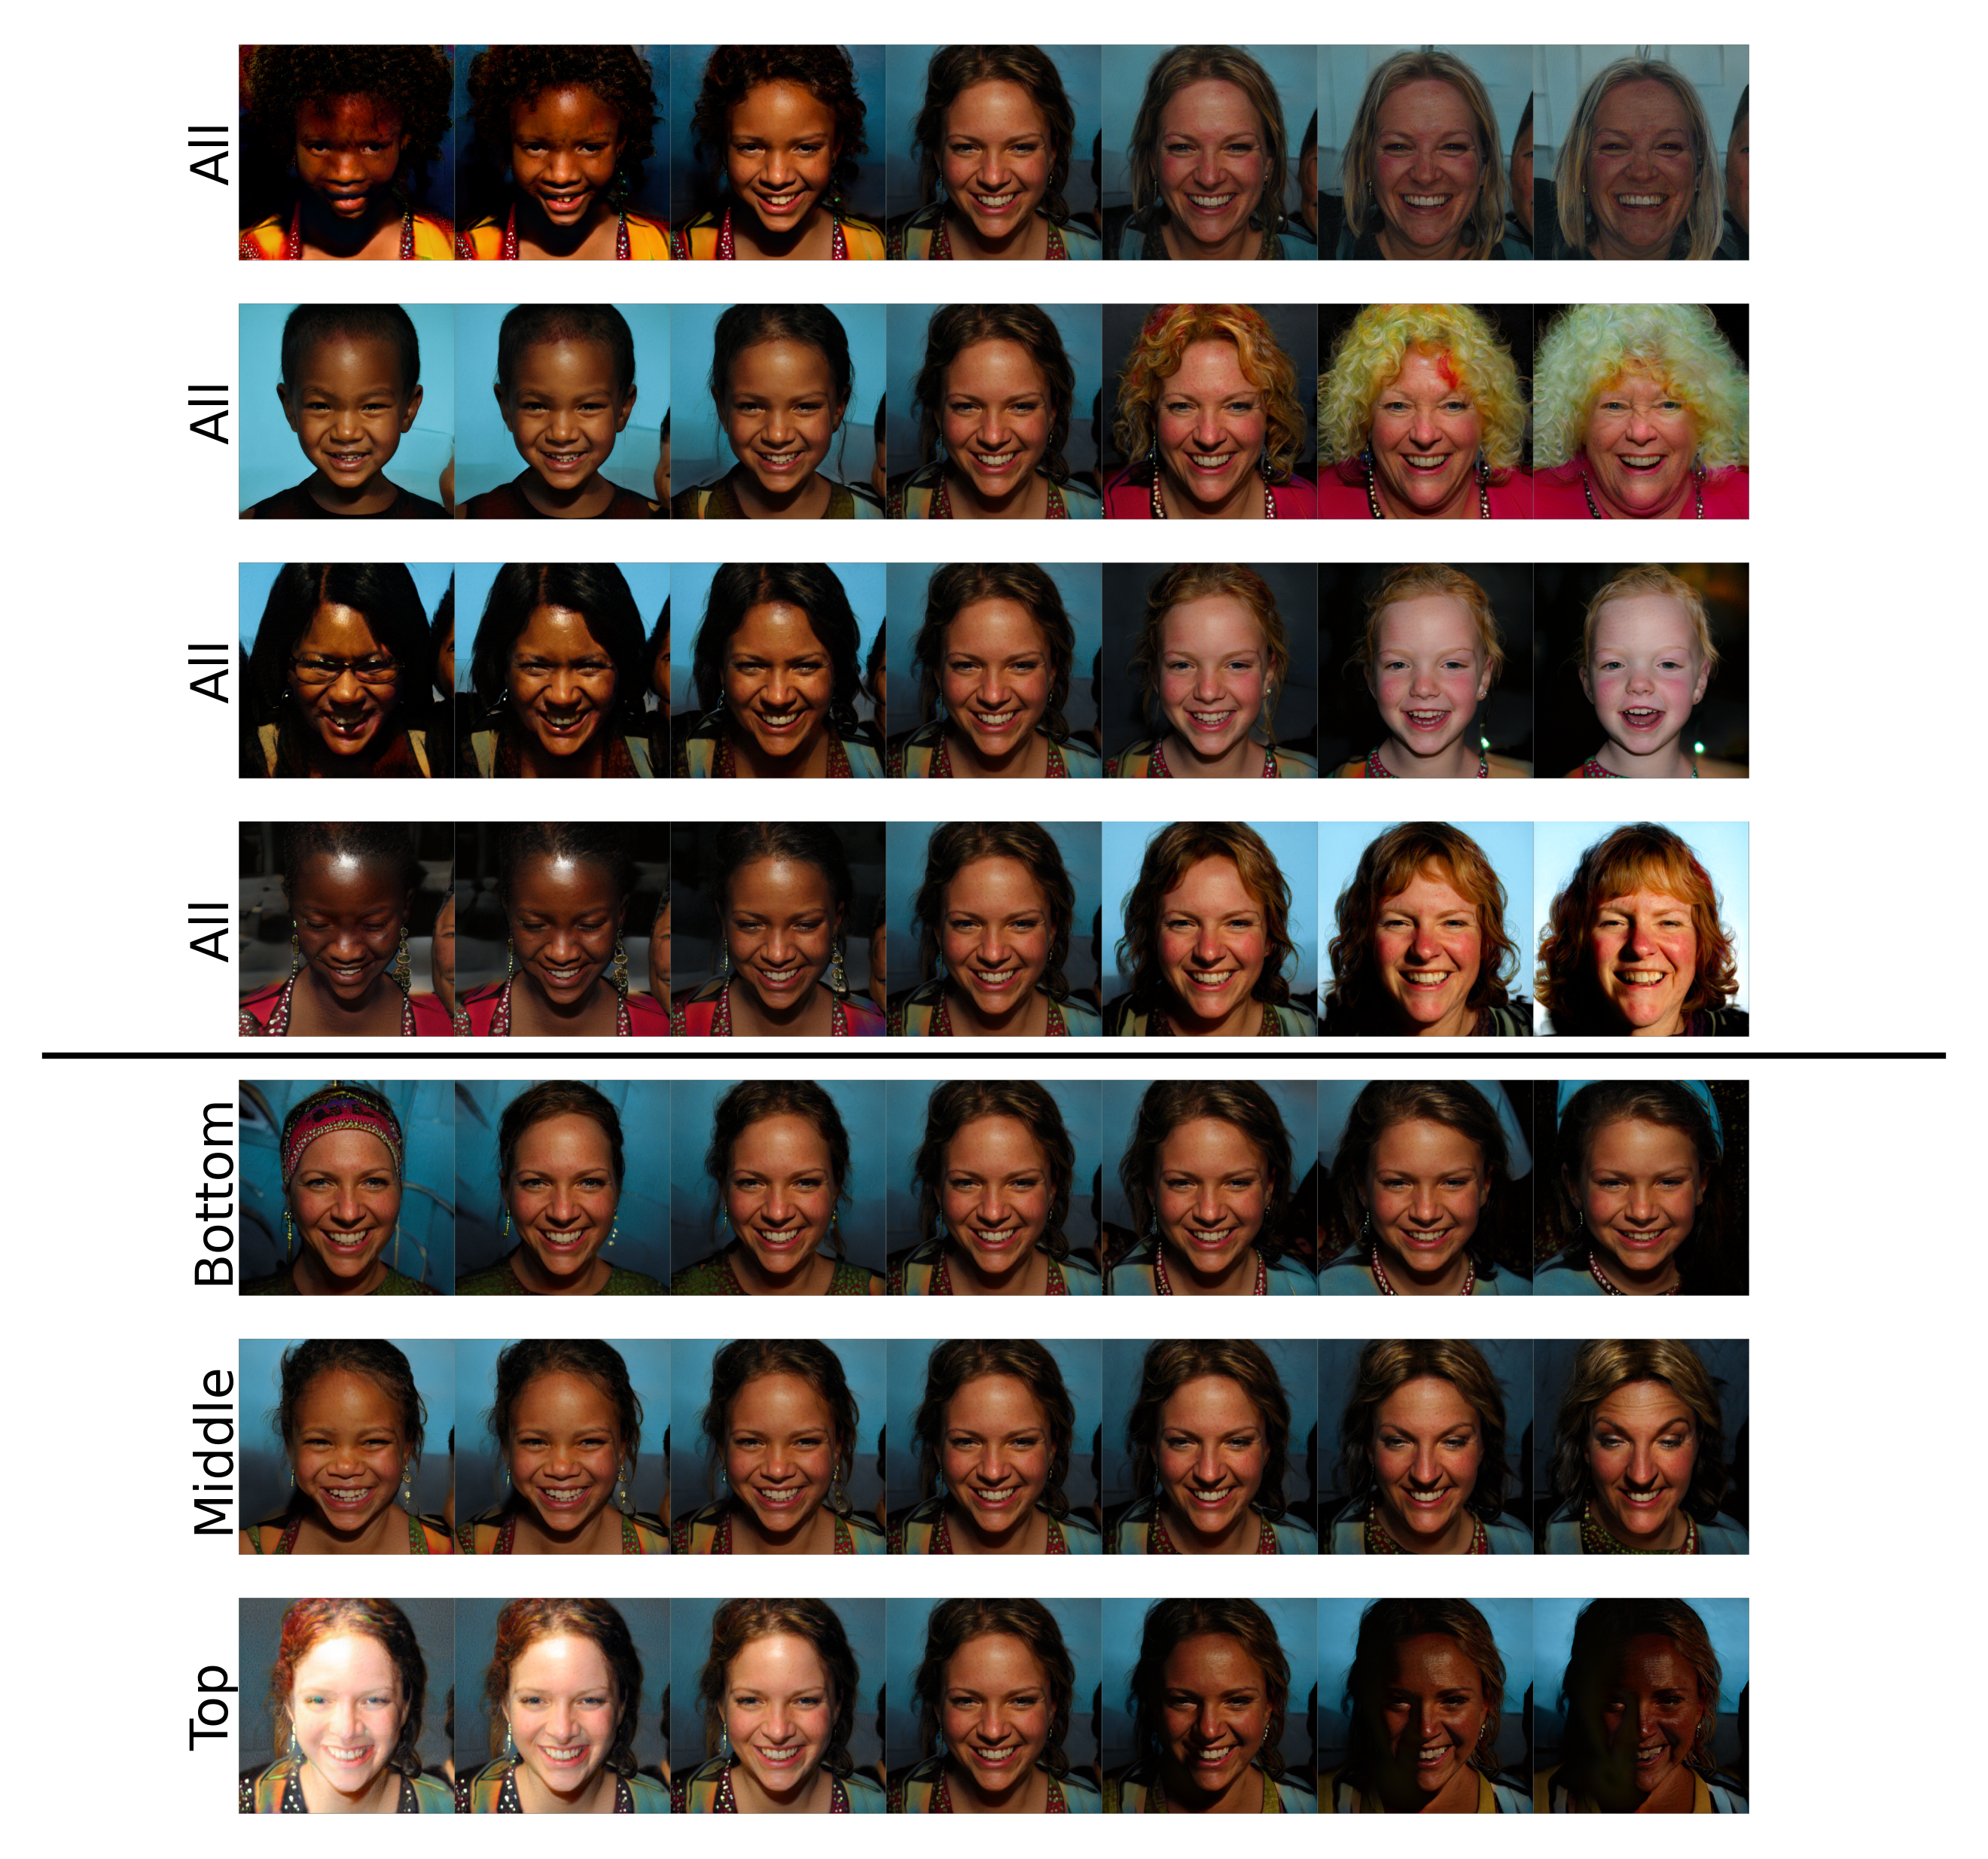

In [ ]:
from PIL import Image
from tqdm import tqdm
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(nrows=7, dpi=600, constrained_layout=True)
code = codes[0:1]
n_layer_ranges = 4
n_components = 512
n_modes = 1
layer_indices = ['all', '0-3', '4-7', '8-17']

pbar = tqdm(range(n_layer_ranges))
for idx in pbar:
  pbar.set_description(desc=f'Analyzing {layer_indices[idx]} layer indices')
  layers, basis, dims = analyze_latent_space('mddgan',
                                             generator,
                                             gan_type,
                                             n_components,
                                             n_modes,
                                             layer_range=layer_indices[idx])
  axs = create_interp_stripes(generator, gan_type, layers, layer_indices[idx], basis.T, code, magnitudes, axs)

# draw horizontal line
line = plt.Line2D([0.15, 0.85], [0.43, 0.43], color="k", linewidth=1)
fig.add_artist(line)